In [1]:
import os
import time
import pickle
import pandas as pd
import numpy as np
import datetime



import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from gensim.utils import simple_preprocess, tokenize
from gensim.summarization.textcleaner import split_sentences
from gensim.parsing import preprocessing
from gensim.models import Doc2Vec
from gensim.corpora import Dictionary


from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn import metrics # silhouette
from sklearn.preprocessing import minmax_scale

import matplotlib.pyplot as plt
from multiprocessing import cpu_count

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import ruptures as rpt
from ruptures.metrics import hausdorff, randindex

from tqdm import tqdm

# pd.set_option('display.max_colwidth',1000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

%matplotlib inline

cuda


In [2]:
df = pd.read_json('data/dev/cluster_12_cats_index.json')

In [3]:
df.head()

,id,date,category
0,3-6475275,2013-01-31T16:59:42+0200,autot
1,3-6475075,2013-01-31T16:02:43+0200,autot
2,3-6474561,2013-01-31T13:24:08+0200,autot
3,3-6474214,2013-01-31T10:54:11+0200,autot
4,3-6474222,2013-01-31T10:54:01+0200,autot


In [4]:
# df.drop(['title', 'body', 'subjects', 'date'], axis=1, inplace=True)

In [5]:
# df.to_json('data/dev/cluster_12_cats_index.json')

In [3]:
doc_vecs = pickle.load(open("data/dev/doc_vecs.pkl", "rb"))

In [4]:
def get_clusters(labels, df, ids):
    df2 = df.reset_index()
    df2 = df2.set_index('id')

    indexes = df2.loc[ids, 'index'].tolist()
    
    clusters = labels[indexes]
    
    return clusters
    

def visualize_trending(df):
#     target = df[df['target'] == True]
#     noise = df[df['target'] == False]
#     t_group = target.groupby(['time'])['id'].count()
#     n_group = noise.groupby(['category'])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    for name, group in df.groupby(['category']):
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()
    
def get_target(df):
    target = df[df['event'] != 'noise']['category'].iloc[0]
    return target

def get_cluster_change(clusters, sample, target, event, timeline=100):
    sample['cluster'] = clusters
    n_cluster = sample['cluster'].nunique()
    changes = []
    
    for g, cluster in sample.groupby('cluster'):
        # count and sort by timeline
        counts = cluster['time'].value_counts().sort_index()
        if len(counts) < timeline:
            miss_times = list(set(range(timeline)).difference(counts.index))
            fill_values = pd.Series(np.zeros(len(miss_times)), index=miss_times)
            counts = counts.append(fill_values)
            counts = counts.sort_index()
            
        # print(cluster['time'].nunique())
        class_count = cluster['category'].value_counts(normalize=True)
        maj_class = class_count.index[0]
        maj_percent = class_count[0]
        # diff = times.diff().fillna(0)
        # print(class_count[0])
        is_target = (maj_class == target) and maj_percent > 0.5
        p = event['pivots'] if is_target else []
        e = event['event'] if is_target else 'noise'
        
        changes.append((counts.values, is_target, maj_class, e, p))
        
    return changes


# def get_cluster_change(clusters, sample, target, event, timeline=100):
#     # sample['cluster'] = clusters
#     changes = []
    
#     for i, ids in enumerate(clusters):
#         cluster = sample.iloc[ids]
#         # count and sort by timeline
#         counts = cluster['time'].value_counts().sort_index()
        
#         if len(counts) < timeline:
#             miss_times = list(set(range(timeline)).difference(counts.index))
#             fill_values = pd.Series(np.zeros(len(miss_times)), index=miss_times)
#             counts = counts.append(fill_values)
#             counts = counts.sort_index()
            
#         # print(cluster['time'].nunique())
#         class_count = cluster['category'].value_counts(normalize=True)
#         maj_class = class_count.index[0]
#         maj_percent = class_count[0]
#         # diff = times.diff().fillna(0)
#         # print(class_count[0])
#         is_target = (maj_class == target) and maj_percent > 0.5
        
#         p = event['pivots'] if is_target else []
#         e = event['event'] if is_target else 'noise'
        
#         changes.append((counts.values, is_target, maj_class, e, p))
        
#     return changes


def get_doc_vecs(doc_vecs, df, ids):
    df2 = df.reset_index()
    df2 = df2.set_index('id')

    indexes = df2.loc[ids, 'index'].tolist()
    # print(len(indexes))
    vecs = doc_vecs[indexes]
    
    return vecs


def kmean_cluster(doc_vecs, df, n_sample, n_clusters=20):
    models = []
    
    for i in tqdm(range(n_sample)):
        sample = pd.read_json('data/dev/samples/sample_' + str(i) + '.json')
        sample.reset_index(inplace=True, drop=True)
        vecs = get_doc_vecs(doc_vecs, df, sample['id'])
        
        model = KMeans(n_clusters=n_clusters, random_state=12).fit(vecs)
        models.append(model)
        
    return models

In [8]:
#models = kmean_cluster(doc_vecs, df, 2000, n_clusters=20)

In [9]:
#pickle.dump(models, open('data/dev/kmean_2k_models.pkl', 'wb'))

In [10]:
# dataset = pickle.load(open("data/prod/sample_7_patterns.pkl", "rb"))

In [11]:
# tracker = pd.read_pickle('data/prod/tracker_7_patterns.pkl')

In [5]:
dataset = pickle.load(open("data/prod/dataset_1_event_2.pkl", "rb"))

In [6]:
tracker = pd.read_pickle('data/prod/dataset_1_pivot_2.pkl')

In [14]:
tracker.sample(5)

,category,event,pivots
941,kulttuuri,up_down,"[42, 66, 90]"
898,taudit,up,"[54, 93]"
1357,työllisyys,up,"[42, 69]"
1738,taudit,up,"[17, 66]"
1494,taudit,up,"[13, 48]"


In [7]:
# kmeans = pickle.load(open('data/dev/kmean_2k_models.pkl', 'rb'))
kmeans = KMeans(n_clusters=20, random_state=2).fit(doc_vecs)

In [8]:
# def get_cluster_freq_change(kmeans, samples, tracker, offset=0):
    
#     all_changes = []
    
#     for i, sample in enumerate(tqdm(samples)):
#         #sample = pd.read_json('data/dev/samples/sample_' + str(i) + '.json')
#         sample.reset_index(inplace=True, drop=True)
#         #sample_vecs = get_doc_vecs(doc_vecs, df, sample['id'])
#         target = get_target(sample)
#         model = kmeans[i+offset]
#         clusters = model.labels_ #get_clusters(model.labels_, df, sample['id'])
#         events = tracker.iloc[i+offset]
#         freq_change = get_cluster_change(clusters, sample, target, events)
        
#         all_changes += freq_change
    
#     return all_changes

def get_cluster_freq_change(model, samples, tracker, df, offset=0):
    
    all_changes = []
    
    for i, sample in enumerate(tqdm(samples)):
        #sample = pd.read_json('data/dev/samples/sample_' + str(i) + '.json')
        sample.reset_index(inplace=True, drop=True)
        # sample_vecs = get_doc_vecs(doc_vecs, df, sample['id'])
        target = get_target(sample)
        clusters = get_clusters(model.labels_, df, sample['id'])
        events = tracker.iloc[i+offset]
        freq_change = get_cluster_change(clusters, sample, target, events)
        
        all_changes += freq_change
    
    return all_changes

def get_freq_change(samples, tracker):
    
    changes = []
    
    for i, sample in enumerate(tqdm(samples)):
        event = tracker.iloc[i]
        counts = sample['time'].value_counts().sort_index()
        # print(class_count[0])
#         p = event['pivots']
#         e = event['event'] if is_target else 'noise'
        
        changes.append((counts.values, event['pivots']))
        
    return changes

# def convert_pivots(pivot_list, timeline=100):
#     point_list = np.zeros((len(pivot_list), 100))
    
#     for i, pivots in enumerate(pivot_list):
        
#         points = np.zeros(timeline, dtype=int)

#         for j in pivots:
#             points[j:] = points[j-1] == 0
            
#         point_list[i] = points
        
#     return point_list

def scale_x(X):
    X = X + 1
    return X / X[:, 0][:, None]

In [9]:
# sample = dataset[0]

In [10]:
# target = get_target(sample)
# clusters = get_clusters(clustering.labels_, df, sample['id'])
# changes = get_cluster_change(clusters, sample, target)

In [119]:
# changes = get_freq_change(dataset, tracker)

100%|██████████| 2000/2000 [00:01<00:00, 1172.36it/s]


In [120]:
# train_data, test_data = train_test_split(changes, test_size=0.1)

In [122]:
# X_train, y_train = zip(*train_data)
# X_val, y_val = zip(*test_data)

In [123]:
# X_train = np.vstack(X_train)
# X_val = np.vstack(X_val)

In [124]:
# X_train = minmax_scale(X_train, axis=1)
# X_val = minmax_scale(X_val, axis=1)

In [11]:
train_samples = dataset[200:]
test_samples = dataset[:200]

In [12]:
train_data = get_cluster_freq_change(kmeans, train_samples, tracker, df, offset=200)

100%|██████████| 1800/1800 [08:07<00:00,  3.69it/s]


In [13]:
test_data = get_cluster_freq_change(kmeans, test_samples, tracker, df)

100%|██████████| 200/200 [00:54<00:00,  3.68it/s]


In [412]:
test_data[:12]

[(array([77, 69, 84, 86, 90, 89, 84, 85, 89, 81, 76, 81, 91, 81, 81, 87, 84,
         85, 86, 78, 84, 79, 81, 83, 84, 85, 79, 84, 86, 81, 87, 79, 83, 87,
         84, 81, 83, 87, 80, 77, 81, 82, 82, 84, 87, 84, 74, 81, 85, 82, 80,
         90, 79, 81, 86, 80, 86, 83, 88, 80, 89, 81, 78, 76, 82, 83, 91, 80,
         77, 84, 76, 89, 88, 76, 85, 82, 88, 77, 86, 80, 87, 80, 84, 87, 90,
         85, 83, 82, 89, 87, 87, 94, 77, 77, 89, 81, 77, 90, 72, 86]),
  False,
  'vaalit',
  'noise',
  []),
 (array([ 86,  81,  90,  94,  79,  94,  92,  91,  85,  93,  94,  80,  75,
          84,  86,  86,  81,  86,  84,  90,  87,  86,  87,  90,  85,  87,
          89,  71,  88,  84,  97,  86,  87,  90,  84,  77,  75,  86,  86,
          85,  79,  90,  86,  78,  88,  73,  80,  97,  81,  77,  84,  79,
          95,  78,  78,  76,  92,  89,  84,  85,  82,  90,  78,  87,  85,
          93,  82,  76,  83,  84,  96,  86,  90,  83,  94,  96,  91,  84,
          80,  90,  78,  92,  83,  75,  90,  90,  93,  84, 10

In [23]:
# test_samples[0]

In [16]:
tracker.head()

,category,event,pivots
250,autot,down_up,"[17, 26, 35]"
736,jääkiekko,up_down,"[77, 82, 88]"
1009,autot,down_up,"[36, 48, 60]"
1057,työllisyys,down,"[40, 91]"
1932,luonto,down,"[22, 91]"


In [14]:
X, targets, _, events, y = zip(*train_data)
X_test, _, maj_cats, events_test, y_test = zip(*test_data)

In [15]:
# points_test = convert_pivots(y_test)
# points = convert_pivots(y)

In [16]:
temp = np.array(tuple(zip(X, events, y)), dtype=object)

In [17]:
ros = RandomOverSampler(random_state=12)
resampled, _ = ros.fit_resample(temp, targets)

In [18]:
X_resampled, events_resampled, y_resampled = zip(*resampled)

In [25]:
# events_resampled[:30]

In [26]:
# y_test[11]

In [19]:
X_resampled = np.vstack(X_resampled)
#y = np.array(y)
X_test = np.vstack(X_test)
#y_test = np.array(y_test)

In [20]:
X_resampled = minmax_scale(X_resampled, axis=1)
X_test = minmax_scale(X_test, axis=1)
# X_resampled = scale_x(X_resampled)
# X_test = scale_x(X_test)

In [30]:
#X_resampled.shape, y_resampled.shape

In [31]:
X[0].shape

(100,)

In [21]:
def visualize_change(sample, model, df, events):    
    fig, ax = plt.subplots(figsize=(20, 10))
    target = get_target(sample)
    clusters = get_clusters(model.labels_, df, sample['id'])
    changes = get_cluster_change(clusters, sample, target, events)
    index = np.arange(100)
    distance = 0
    
    counts, is_target, cats, event, pivots = zip(*changes)
    counts = np.array(counts) + 1
    # print(counts.shape)
    counts = counts / counts[:, 0][:,None]
    # print(counts[-1])
    
    
    for i, change in enumerate(is_target):
        val = counts[i] + distance
        
        if change:
            print(event[i])
            print(pivots[i])
            ax.plot(index, val, ls='--')
        else:
            ax.plot(index, val)
            
        distance += 1
    
    ax.set(xlabel='Time', ylabel='Counts')
    # ax.legend()
    ax.grid()

    plt.show()

def visualize_train_data(X, y, y_true=[]):    
    fig, ax = plt.subplots(figsize=(20, 10))
    index = np.arange(100)
    
    ax.plot(index, X)
    ax.vlines(y, ymin=0, ymax=1, color='red')
    ax.vlines(y_true, ymin=0, ymax=1, color='green')
    
    ax.set(xlabel='Time', ylabel='Counts')
    # ax.legend()
    ax.set_ylim(0)
    ax.grid()
    ax.set_xticks(range(0, 100, 2))

    plt.show()
    
# def scale_2(X):
#     X = X + 1
#     print(X[0])
#     D = np.diff(X, axis=1)
#     print(D[0])
#     S = X[:, 1:] + X[:, :-1]
#     print(S[0])
#     avg = D / S
#     z = np.zeros((X.shape[0], 1))
#     avg = np.concatenate((z, avg), axis=1)
#     # avg = minmax_scale(avg, axis=1)
    
#     return avg

def scale_2(X):
    X = X + 1
    print(X[0])
    D = np.diff(X, axis=1, prepend=0)
    print(D[0])
    S = np.mean(X, axis=1)
    # S = X[:, 1:] + X[:, :-1]
    print(S[0])
    avg = D / S[:, None]
    avg = np.nancumsum(avg, axis=1)
#     z = np.zeros((X.shape[0], 1))
#     avg = np.concatenate((z, avg), axis=1)
    # avg = minmax_scale(avg, axis=1)
    print(avg[0])
    return avg

In [30]:
#X_scale_2 = minmax_scale(X_resampled, axis=1)

In [29]:
# X_scale_2 = scale_2(X_resampled)

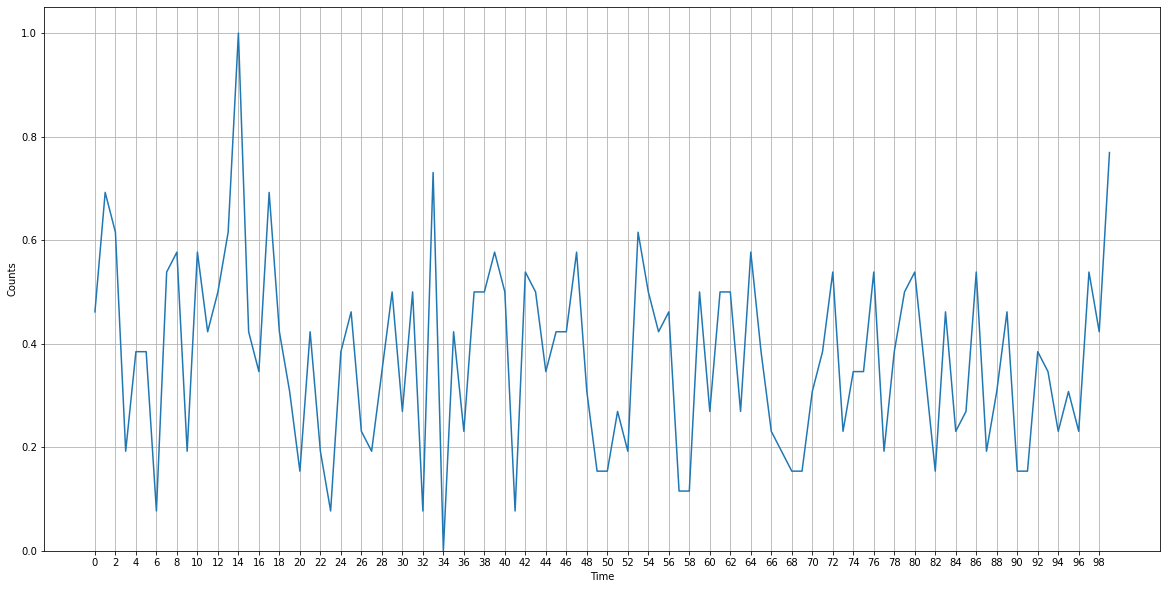

In [22]:
visualize_train_data(X_resampled[56], y_resampled[56])

In [40]:
# visualize_train_data(X_resampled[13], y_resampled[2])

In [730]:
# randid = np.random.randint(2000)
# sample = dataset[randid]
# print(randid)
# visualize_change(sample, clustering, df, pivot_data.iloc[randid])

In [23]:
X_train, X_val, y_train, y_val, e_train, e_val = train_test_split(X_resampled, y_resampled, events_resampled, test_size=0.1)

In [32]:
X_val.shape

(6632, 100)

In [24]:
class SeqDataset(Dataset):

    def __init__(self, X, pivots, events=None, timeline=100):
        self.X = X
        self.pivots = pivots
        self.timeline = timeline
        self.events = events

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        src = self.X[idx]
        #trg = torch.zeros(self.timeline, dtype=torch.long)
        event = self.events[idx]
        
        if event == 'noise':
            is_target = torch.tensor(0, dtype=torch.float)
        else:
            is_target = torch.tensor(1, dtype=torch.float)
        
        trg = self.format_pivots(event, self.pivots[idx])
#         for i in self.pivots[idx]:
#             trg[i:] = trg[i-1] == 0
            
        #sos = torch.tensor([1])
        #eos = torch.tensor([2])
        
        src = torch.tensor(src, dtype=torch.float)
        # src = torch.cat((sos, src, eos))
        # trg = torch.cat((sos, trg, eos))
        # add sos and eos token id
        # print(F.one_hot(trg))
        # print(self.events[idx], self.pivots[idx])
        return src, trg, is_target

        
    def format_pivots(self, event, pivots):
        cur = 0
        points = torch.zeros(self.timeline, dtype=torch.long)
        for p in pivots:
            if points[p] == cur:
                points[p:] = cur + 1
                cur += 1
#             else:
#                 points[p:] = 3
                
        return points
    
    def format_pivots_2(self, event, pivots):
        
        points = torch.zeros(self.timeline, dtype=torch.float)
        
        if event == 'spike_up':
            for p in pivots:
                points[p-2: p] = 1
                points[p: p+3] = 1
                
        elif event == 'spike_down':
            for p in pivots:
                points[p-2: p] = -1
                points[p: p+3] = -1
                
        elif event == 'up_down':
            points[pivots[0]: pivots[1]] = 1
            points[pivots[1]: pivots[2]] = -1
            
        elif event == 'down_up':
            points[pivots[0]: pivots[1]] = -1
            points[pivots[1]: pivots[2]] = 1
            
        elif event == 'up':
            points[pivots[0]: pivots[1]] = 1
            
        elif event == 'down':
            points[pivots[0]: pivots[1]] = -1
            
        else:
            pass
        
        return points


In [25]:
train_set = SeqDataset(X_train, y_train, e_train)
val_set = SeqDataset(X_val, y_val, e_val)
test_set = SeqDataset(X_test, y_test, events_test)

# train_set = SeqDataset(X_train, y_train)
# val_set = SeqDataset(X_val, y_val)
# test_set = SeqDataset(X_test, y_test)
                      
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4)

In [31]:
train_set[np.random.randint(24)]

(tensor([0.6600, 0.4600, 0.6000, 0.7800, 0.7600, 0.4600, 0.3600, 0.7200, 0.6600,
         0.5600, 0.6600, 0.7800, 0.7800, 0.6400, 0.4200, 0.8600, 0.7200, 0.9400,
         0.7800, 0.7000, 0.3800, 0.3800, 0.7600, 0.8600, 0.5200, 0.5600, 0.5600,
         0.6600, 0.6600, 0.6000, 0.3800, 0.9600, 0.2800, 0.2400, 0.6200, 0.6200,
         0.5200, 0.8800, 0.8200, 0.7400, 0.5600, 0.5600, 0.6200, 0.7400, 0.7000,
         0.7000, 0.6800, 0.6400, 0.9600, 0.9000, 0.4800, 0.4200, 0.5400, 1.0000,
         0.6600, 0.9800, 0.4200, 0.4400, 0.4800, 0.4800, 0.3600, 0.7800, 0.7800,
         0.6000, 0.7600, 0.6600, 0.7000, 0.6800, 0.8400, 0.5400, 0.5600, 0.3800,
         0.6600, 0.6600, 0.5400, 0.8400, 0.5200, 0.7800, 0.7800, 0.5600, 0.6200,
         0.0000, 0.6600, 0.6400, 0.7200, 0.6600, 0.4600, 0.6000, 0.5800, 0.5800,
         0.8800, 0.5200, 0.6800, 0.7400, 0.4400, 0.6800, 0.6200, 0.7800, 0.5600,
         0.6200]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         

In [541]:
test_set[14]

(tensor([0.2727, 0.2727, 0.4545, 0.4242, 0.2121, 0.2121, 0.4242, 0.3939, 0.3939,
         0.4848, 0.6667, 0.3030, 0.4848, 0.2424, 0.3939, 0.4848, 0.4242, 0.3636,
         0.4545, 0.5152, 0.6061, 0.3939, 0.3636, 0.4242, 0.8485, 0.1515, 0.3939,
         0.5758, 0.2121, 0.3939, 0.6061, 0.3030, 0.3333, 0.4242, 0.3636, 0.4545,
         0.3333, 0.2121, 0.7576, 0.2727, 0.4242, 0.4848, 0.4242, 0.2424, 0.2727,
         0.3939, 0.3939, 0.2727, 0.4242, 0.4848, 0.5455, 0.5455, 0.4848, 0.4242,
         0.2424, 0.4848, 0.4545, 0.0000, 0.5758, 0.6061, 0.6364, 0.3939, 0.4242,
         0.5758, 0.4848, 0.6364, 0.1818, 0.4242, 0.4545, 0.2121, 0.3030, 0.5455,
         0.6667, 0.4545, 0.3939, 0.4545, 0.2424, 0.3030, 0.2727, 0.3030, 0.3939,
         0.4545, 0.6970, 0.3030, 0.0909, 0.4848, 0.0606, 0.3333, 0.9091, 0.2424,
         0.1818, 0.3333, 0.5758, 0.5152, 0.4848, 1.0000, 0.4848, 0.5455, 0.9394,
         0.3939]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [33]:
class Seq2SeqModel(nn.Module):
    
    def __init__(self, hid_dim, out_dim, cov_dim=8, dropout=0.5, device=device):
        super(Seq2SeqModel, self).__init__()
        
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.cov_dim = cov_dim
        self.device = device
        self.embed = torch.nn.Embedding(out_dim, hid_dim)
        seq_len = 100
        
        
        # encode time series relation of input
        self.encoder = nn.GRU(1, hid_dim, bidirectional=True, batch_first=True)  # (batch, 100, 128) + (batch, 128)
        self.decoder = nn.GRU(23 * 16 + hid_dim * 2 + out_dim, hid_dim, bidirectional=True, batch_first=True)

        # in: b, 100 => out: b, 128, 1
        # encode patterns of input to predict if it is a trend or not
        
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0),  # (100 - 3) + 1 = 98
            nn.ReLU(True),
            nn.MaxPool1d(2, 2),  # (98 - 2) / 2 + 1 = 49
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0), # (49 - 3) + 1 = 47
            nn.ReLU(True),
            nn.MaxPool1d(3, 2), # (47 - 3) / 2 + 1 = 23
        )
        
        # use both RNN encoded and CNN output for decoder
        
        self.seq_out = nn.Linear(hid_dim * 2, out_dim)
        self.fc = nn.Linear(23 * 16 + hid_dim * 2, hid_dim)
        
        self.bin_out = nn.Linear(hid_dim, 1)
        self.dropout = nn.Dropout(dropout)
    

    def conv_block(self, inputs, conv_layer):
        X = inputs.unsqueeze(1)
        batch_size = X.shape[0]
        conv_out = conv_layer(X)
        
        mu = torch.zeros(self.cov_dim).to(self.device) # zeros are fine for first training iter
        std = torch.ones(self.cov_dim).to(self.device)
        
        # conv_out = conv_out.squeeze(3)
        conv_out = F.batch_norm(conv_out, running_mean=mu, running_var=std, training=True)
        
        # b, hid_dim, 94, 
        # b, hid_dim, 91
        # b, hid_dim, 82,
        
        activated = F.relu(conv_out)  # activated.size() = (batch_size, out_channels, dim1)
        max_out = F.max_pool1d(activated, 2) #.squeeze(2) # maxpool_out.size() = (batch_size, out_channels)
    
        return max_out.view(batch_size, -1)
    

    def encode(self, X):
        X = X.unsqueeze(2)
        #print('src', src.shape)
        out, hid = self.encoder(X)  # out: batch, len, hid
        #print('out', out.shape)
        #out = F.avg_pool2d(out, (out.size()[1], 1) ).squeeze(1)   # out batch, hid
        #print('out', out.shape)
        return out, hid
    
    def decode(self, X, hidden, context):
        batch_size = X.shape[0]
        # print('input', input.shape)
        one_hot = F.one_hot(X.unsqueeze(0), num_classes=self.out_dim).to(torch.float)
        # embeded = self.embed(X)
        #print('onehot', one_hot.shape)
        #print('ctx', context.shape)
        # print('embed', embeded.shape)
        merge_ctx = torch.cat((one_hot.view(batch_size, -1), context), dim=1)
        #merge_ctx = torch.cat((embeded, context), dim=1)
        #print('merge', merge_ctx.shape)
        
        out, hid = self.decoder(merge_ctx.unsqueeze(1), hidden)
        #print('cov_out', conv_out.shape)
        #print('hid', hid.shape)
        # out = torch.mean(out, dim=1)
        #cat = torch.cat((out.view(batch_size, -1), context), dim=1)
        #print('cat', cat.shape)

        pred = self.seq_out(out.view(batch_size, -1))
        
        return pred, hid
        
    
    def forward(self, src, trg, teacher_enforce=0):
        batch_size = src.shape[0]
        trg_len = src.shape[1]
        
        conv_out = self.conv(src.unsqueeze(1))
        
#         print('cv1', conv_out1.shape)
#         print('cv2', conv_out2.shape)
#         print('cv3', conv_out3.shape)
        
        #conv_out = torch.cat((conv_out1, conv_out2, conv_out3), 1)
        
        #tensor to store decoder outputs
        #trg = torch.zeros(batch_size, trg_len, self.out_dim).to(self.device)
        #assign the sos to the first output (mark index 1 is True)
        #trg[:, 0, 3] = 1
        #last hidden state of the encoder is the context
        _, hidden = self.encode(src)
        #print('rnn_ctx', hidden.shape)

        rnn_out = hidden.reshape(batch_size, -1)
        #print('context', context.shape)
        conv_out = conv_out.view(batch_size, -1)
        
        context = self.dropout(torch.cat((conv_out, rnn_out), 1))
        
        fc_out = self.fc(context)
        
        bin_out = self.bin_out(F.relu(fc_out))
        bin_out = torch.sigmoid(bin_out)
        
        #seq_out = self.seq_out(F.relu(fc_out))
        
        seq_out = torch.zeros(batch_size, trg_len, self.out_dim).to(self.device)
        seq_in = trg[:, 0]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and the context state
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decode(seq_in, hidden, context)
            #print('output', output.shape)
            #place predictions in a tensor holding predictions for each token
            seq_out[:, t] = output
            if np.random.rand() < teacher_enforce:
                seq_in = trg[:, t]
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            else:
                seq_in = output.argmax(1)
        
        return seq_out, bin_out


In [34]:
model = Seq2SeqModel(hid_dim=256, out_dim=10).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10]).to(device))

In [35]:
def train(model, data_loader, optimizer, criterion=None):
    model.train()
    epoch_loss = 0
    # for i, batch in tqdm(enumerate(data_loader), total=len(data_loader), desc='Train'):
    for batch in data_loader:
        inputs, seq_labels, bin_labels = batch
        inputs = inputs.to(device)
        seq_labels = seq_labels.to(device)
        bin_labels = bin_labels.to(device)
        
        #print('inputs', inputs.shape)
        #print('labels', labels.shape)
        
        seq_outs, bin_outs = model(inputs, seq_labels, 0.2)

        #print('output', outputs.shape)

        # outputs = outputs.squeeze(1)
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
#         print(outputs)
#         print(labels)
        output_dim = seq_outs.shape[-1]
        #seq_outs = seq_outs.permute(0, 2, 1)
        seq_outs = seq_outs.reshape(-1, output_dim)
        seq_labels = seq_labels.reshape(-1)
        bin_outs = bin_outs.squeeze(1)
        
        optimizer.zero_grad()
        loss1 = criterion1(seq_outs, seq_labels)
        loss2 = criterion2(bin_outs, bin_labels)
        
        loss = loss1 + loss2
        
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(data_loader)

def evaluate(model, data_loader, criterion=None):
    model.eval()
    epoch_loss = 0
    # y_pred = torch.tensor([], dtype=bool).to(device)
    # y_true = torch.tensor([], dtype=bool).to(device)
    
    with torch.no_grad():
        for batch in data_loader:
            inputs, seq_labels, bin_labels = batch
            inputs = inputs.to(device)
            seq_labels = seq_labels.to(device)
            bin_labels = bin_labels.to(device)

            seq_outs, bin_outs = model(inputs, seq_labels)
            output_dim = seq_outs.shape[-1]
            #seq_outs = seq_outs.permute(0, 2, 1)
            seq_outs = seq_outs.reshape(-1, output_dim)
            seq_labels = seq_labels.reshape(-1)
            bin_outs = bin_outs.squeeze(1)
            
            loss1 = criterion1(seq_outs, seq_labels)
            loss2 = criterion2(bin_outs, bin_labels)

            loss = loss1 + loss2
            epoch_loss += loss.item()
            # y_true = torch.cat([y_true, labels])
            
#             accuracy += (preds == labels).sum()
#             n_sample += len(labels)
    
    epoch_loss = epoch_loss / len(data_loader)
    # accuracy = accuracy.cpu().item()
    # accuracy = accuracy / n_sample
    return epoch_loss

def test(model, data_loader, criterion=None):
    model.eval()
    epoch_loss = 0
    y_bin = torch.tensor([], dtype=bool).to(device)
    y_seq = torch.tensor([], dtype=bool).to(device)
    # y_true = torch.tensor([], dtype=bool).to(device)
    
    with torch.no_grad():
        for batch in data_loader:

            inputs, seq_labels, bin_labels = batch
            inputs = inputs.to(device)
            seq_labels = seq_labels.to(device)
            bin_labels = bin_labels.to(device)

            seq_outs, bin_outs = model(inputs, seq_labels)
            

            # print('output', outputs.shape)
#             print('labels', labels.shape)
#         print(labels)
            bin_outs = bin_outs.squeeze(1)
            bin_pred = bin_outs >= 0.5
        
#             seq_pred = torch.where(seq_outs <= -0.66, torch.tensor(-1.0).to(device), seq_outs)
#             seq_pred = torch.where((seq_pred > -0.66) & (seq_pred < 0.33), torch.tensor(0.0).to(device), seq_pred)
#             seq_pred = torch.where(seq_pred >= 0.66, torch.tensor(1.0).to(device), seq_pred)
    
            # print(preds.shape)
            seq_pred = torch.argmax(seq_outs, 2)
            y_seq = torch.cat([y_seq, seq_pred])
            y_bin = torch.cat([y_bin, bin_pred])
        
            output_dim = seq_outs.shape[-1]
            seq_outs = seq_outs.reshape(-1, output_dim)
            #seq_outs = seq_outs.permute(0, 2, 1)
            seq_labels = seq_labels.reshape(-1)
            

            loss1 = criterion1(seq_outs, seq_labels)
            loss2 = criterion2(bin_outs, bin_labels)

            loss = loss1 + loss2
            epoch_loss += loss.item()
            # y_true = torch.cat([y_true, labels])
            
#             accuracy += (preds == labels).sum()
#             n_sample += len(labels)
    
    epoch_loss = epoch_loss / len(data_loader)
    # accuracy = accuracy.cpu().item()
    # accuracy = accuracy / n_sample
    return epoch_loss, y_bin.cpu().numpy(), y_seq.cpu().numpy()

# def get_pivots(pred):
#     pivots = []
    
#     cur = 0
#     for i, v in enumerate(pred[:-1]):
#         if v != 0 and v != 1:
#             # print(v)
#             continue
#         if v != cur:
#             pivots.append(i)
#             cur = v
#     return pivots
            
    

In [130]:
N_EPOCH = 30
for epoch in range(N_EPOCH):
    
    t0 = time.time()
    
    train_loss = train(model, train_loader, optimizer)
    val_loss = evaluate(model, val_loader)
    
    duration = (time.time() - t0) / 60
    # print(f'Train Loss: {train_loss:.4f}')
    # f1 = f1_score(y_true, y_pred)
    print(f'Epoch: {epoch+1} | Time: {duration:.2f} mins | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')
    # print(classification_report(y_true, y_pred))


Epoch: 1 | Time: 2.65 mins | Train Loss: 0.439 | Val Loss: 1.248
Epoch: 2 | Time: 2.61 mins | Train Loss: 0.435 | Val Loss: 1.130
Epoch: 3 | Time: 2.66 mins | Train Loss: 0.431 | Val Loss: 1.233
Epoch: 4 | Time: 2.63 mins | Train Loss: 0.431 | Val Loss: 1.136
Epoch: 5 | Time: 2.63 mins | Train Loss: 0.427 | Val Loss: 1.212
Epoch: 6 | Time: 2.73 mins | Train Loss: 0.427 | Val Loss: 1.165
Epoch: 7 | Time: 2.67 mins | Train Loss: 0.421 | Val Loss: 1.186
Epoch: 8 | Time: 2.60 mins | Train Loss: 0.417 | Val Loss: 1.166
Epoch: 9 | Time: 2.66 mins | Train Loss: 0.416 | Val Loss: 1.103
Epoch: 10 | Time: 2.68 mins | Train Loss: 0.414 | Val Loss: 1.194
Epoch: 11 | Time: 2.64 mins | Train Loss: 0.414 | Val Loss: 1.028
Epoch: 12 | Time: 2.66 mins | Train Loss: 0.409 | Val Loss: 1.033
Epoch: 13 | Time: 2.63 mins | Train Loss: 0.406 | Val Loss: 1.115
Epoch: 14 | Time: 2.64 mins | Train Loss: 0.404 | Val Loss: 1.143
Epoch: 15 | Time: 2.62 mins | Train Loss: 0.401 | Val Loss: 1.144
Epoch: 16 | Time: 2

In [44]:
torch.save(model.state_dict(), 'models/rnn/rnn_seq_kmeans.pt')

In [ ]:
# now test with LDA

In [131]:
test_loss, y_bin, y_seq = test(model, test_loader)

In [132]:
test_loss

0.36953270955691264

In [120]:
sum(y_bin)

252

In [133]:
"""
Check if the sample has the changed event
Predict the pivot points for that changed event
The metric is rand index average by number of samples
"""

def get_result(y_bin, y_seq):
    founds = []
    # founds = np.where(y_bin > 0)[0]
    
    for i, (x, p) in enumerate(zip(y_bin, y_seq)):
        pivots = get_pivots(p)
        if len(pivots) and x:
            founds.append(i)
    return founds


def get_pivots(pred):
    pivots = []

    cur = pred[0]
    for i, v in enumerate(pred):
#         if v == 1 or v == 2:
#             # print(v)
#             continue
        if v != cur:
            pivots.append(i)
            cur = v
    return pivots


# def get_metrics(y_true, y_pred):
#     timeline = 100
#     avg = 0
    
#     pred_pivots = []
    
#     for i, p in enumerate(y_pred):
#         pivots = get_pivots(p)
#         if len(pivots):
#             founds.append(i)
    
#     for t, p in zip(pv_true, pv_pred):
#         t = np.concatenate((t, [timeline]))
#         p = np.concatenate((p, [timeline]))
#         ridx = randindex(t, p)
        
#         avg += ridx
#     avg = avg / len(pv_true)
    
#     return avg

In [134]:
#y_pred[2191]

In [135]:
dcm = get_result(y_bin, y_seq)

In [136]:
len(dcm)

288

In [162]:
test_id = np.random.choice(dcm)
print(test_id)

2805


In [163]:
get_pivots(y_seq[test_id])

[24, 92]

In [164]:
y_test[test_id]

array([20, 82])

In [165]:
#y_seq[test_id]

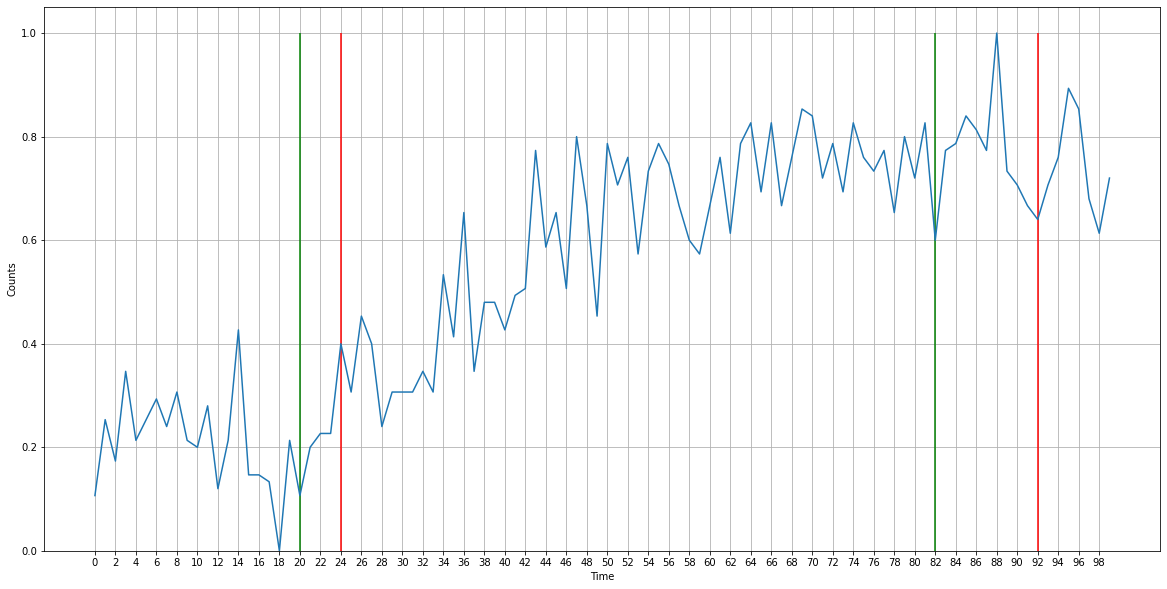

In [166]:
visualize_train_data(X_test[test_id], get_pivots(y_seq[test_id]), y_test[test_id])

In [167]:
def get_metrics(df, y_true, y_bin, y_seq, maj_cats, events, target):
    accuracy = 0   # accuracy of detect correctly clusters have the target category as major
    precision = 0  # accuracy of detect how many articles in cluster are target category
    recall = 0    # accuracy of detect how many articles in target category are in choosen clusters
    randidx = 0
    timeline = 100
    
    pred_ids = get_result(y_bin, y_seq)

    for i in pred_ids:

        true_points = y_true[i]

        if len(true_points):
            pred_points = get_pivots(y_seq[i])
            # print(pred_points)
            true_points = np.concatenate((true_points, [timeline]), axis=0).astype(int)

            if timeline not in pred_points:
                pred_points = np.concatenate((pred_points, [timeline]), axis=0).astype(int)
            # print(t, p)
            # print(true_points)
            randidx += randindex(true_points, pred_points)
    
    # pred_ids = np.argwhere(y_pred > 0).squeeze(1)
    n_cluster = len(pred_ids)

    df['target'] = (df['event'] != 'noise')
    target_cluster = df[df['target'] == True]
    
    for i in pred_ids:
        pred_cat = maj_cats[i]
        cluster = df[df['cluster'] == i]
        
        if pred_cat == target:
            accuracy += 1
        # calculate the prec and recall
        if len(cluster['target']) > 0:
            precision += cluster['target'].mean()
        recall += cluster['target'].sum()
    
    # if there is output 
    if n_cluster:
        accuracy = accuracy / n_cluster
        precision = precision / n_cluster
        randidx = randidx / n_cluster
    
    recall = recall / target_cluster.shape[0]
    
    return accuracy, precision, recall, randidx


def evaluate_pipeline(samples, labels, y_bin, y_seq, maj_cats, events):
    n_samples = len(samples)
    acc = np.zeros(n_samples)
    prc = np.zeros(n_samples)
    rec = np.zeros(n_samples)
    f = np.zeros(n_samples)
    rid = np.zeros(n_samples)
    n_cluster = 20
    
    for i, sample in enumerate(tqdm(samples)):
        target = get_target(sample)
        y_true = labels[i*n_cluster: (i+1)*n_cluster]
        seqs = y_seq[i*n_cluster: (i+1)*n_cluster]
        bins = y_bin[i*n_cluster: (i+1)*n_cluster]
        
        # pivots = [get_pivots(p) for p in y_pred]
        cats = maj_cats[i*n_cluster: (i+1)*n_cluster]
        evts = events[i*n_cluster: (i+1)*n_cluster]
        # clusters = pickle.load(open("models/lda_cluster/clusters_" + str(i) + ".pkl", "rb"))
        
        acc[i], prc[i], rec[i], rid[i] = get_metrics(sample, y_true, bins, seqs, cats, evts, target)
        if (prc[i] + rec[i]) != 0:
            f[i] = 2 * prc[i] * rec[i] / (prc[i] + rec[i])
        
    return acc, prc, rec, rid, f



In [168]:
accs, precs, recs, rid, f_micro = evaluate_pipeline(test_samples, y_test, y_bin, y_seq, maj_cats, events_test)

100%|██████████| 200/200 [00:04<00:00, 48.11it/s]


In [173]:
# randindex([ 10, 30,  50,  70,  90, 100], [ 12, 101, 100])

In [169]:
f_macro =2 * precs.mean()*recs.mean()/(precs.mean()+recs.mean())
accs.mean(), precs.mean(), recs.mean(), rid.mean()

(0.7783333333333334,
 0.6098145989988335,
 0.5710193852066748,
 0.6394945833333333)

In [76]:
f_micro = np.nan_to_num(f_micro)
print("f_micro:", f_micro.mean(), "f_macro:", f_macro)

f_micro: 0.531944851986538 f_macro: 0.55513822184396


In [ ]:
# Now evaluate historical data

In [190]:
# 1. load stt vecs
# 2. train stt kmeans
# 3. 
def get_stt_changes():
    changes = pickle.load(open("models/stt/stt_changes.pkl", "rb"))
    #changes = np.concatenate([changes, np.zeros((50,36))], 1)
    X = np.zeros((len(changes), 100))
    
    for i, s in enumerate(changes):
        #print(s.index, s.values)
        #X[i][s.index] = s.values
        X[i] = s[2].values
    
    X = minmax_scale(X, axis=1)
    
    return X

def infer(model, inputs):
    model.eval()
    y_bin = torch.tensor([], dtype=bool).to(device)
    y_seq = torch.tensor([], dtype=bool).to(device)
    
    with torch.no_grad():
        inputs = torch.tensor(inputs, dtype=torch.float).to(device)
        labels = torch.zeros(inputs.shape, dtype=torch.long).to(device)

        seq_outs, bin_outs = model(inputs, labels)

        bin_outs = bin_outs.squeeze(1)
        bin_pred = bin_outs >= 0.5
        seq_pred = torch.argmax(seq_outs, 2)
#         seq_pred = torch.where(seq_outs <= -0.5, torch.tensor(-1.0).to(device), seq_outs)
#         seq_pred = torch.where((seq_pred > -0.5) & (seq_pred < 0.5), torch.tensor(0.0).to(device), seq_pred)
#         seq_pred = torch.where(seq_pred >= 0.5, torch.tensor(1.0).to(device), seq_pred)

        # print(preds.shape)
        y_seq = torch.cat([y_seq, seq_pred])
        y_bin = torch.cat([y_bin, bin_pred])
            
    return y_bin.cpu().numpy(), y_seq.cpu().numpy()


def visualize_changes(changes):    
    fig, ax = plt.subplots(figsize=(20, 10))

    index = np.arange(changes.shape[1])
    distance = 0
    
    for i, change in enumerate(changes):
        val = change + distance
        ax.plot(index, val, label=str(i))
            
        distance += 0.5
        
#         if i == 10:
#             break
    
    ax.set(xlabel='Time', ylabel='Counts')
    ax.legend()
    ax.grid()
    ax.set_xticks(range(0, changes.shape[1], 2))
    # ax.set_xlim(0, 63)
    # ax.set_ylim(0, 5)

    plt.show()

In [191]:
stt_changes = get_stt_changes()

In [192]:
stt_changes[0].shape

(100,)

In [193]:
X_train[0]

array([0.33333333, 0.88888889, 0.55555556, 0.66666667, 0.        ,
       0.11111111, 0.33333333, 0.55555556, 0.44444444, 0.22222222,
       0.88888889, 0.55555556, 0.33333333, 0.44444444, 0.22222222,
       0.77777778, 0.33333333, 0.44444444, 0.44444444, 0.        ,
       0.33333333, 0.22222222, 0.33333333, 0.55555556, 0.66666667,
       0.66666667, 0.33333333, 0.55555556, 0.55555556, 0.22222222,
       0.33333333, 0.55555556, 0.33333333, 0.33333333, 0.44444444,
       0.44444444, 0.55555556, 0.55555556, 0.33333333, 0.33333333,
       1.        , 0.77777778, 0.11111111, 0.33333333, 0.33333333,
       0.33333333, 0.66666667, 0.55555556, 0.44444444, 0.22222222,
       0.33333333, 0.22222222, 0.55555556, 0.33333333, 0.44444444,
       0.55555556, 0.22222222, 0.77777778, 0.44444444, 0.66666667,
       0.44444444, 0.22222222, 0.11111111, 0.77777778, 0.33333333,
       0.66666667, 0.11111111, 1.        , 0.22222222, 0.88888889,
       0.44444444, 0.44444444, 0.77777778, 0.55555556, 0.33333

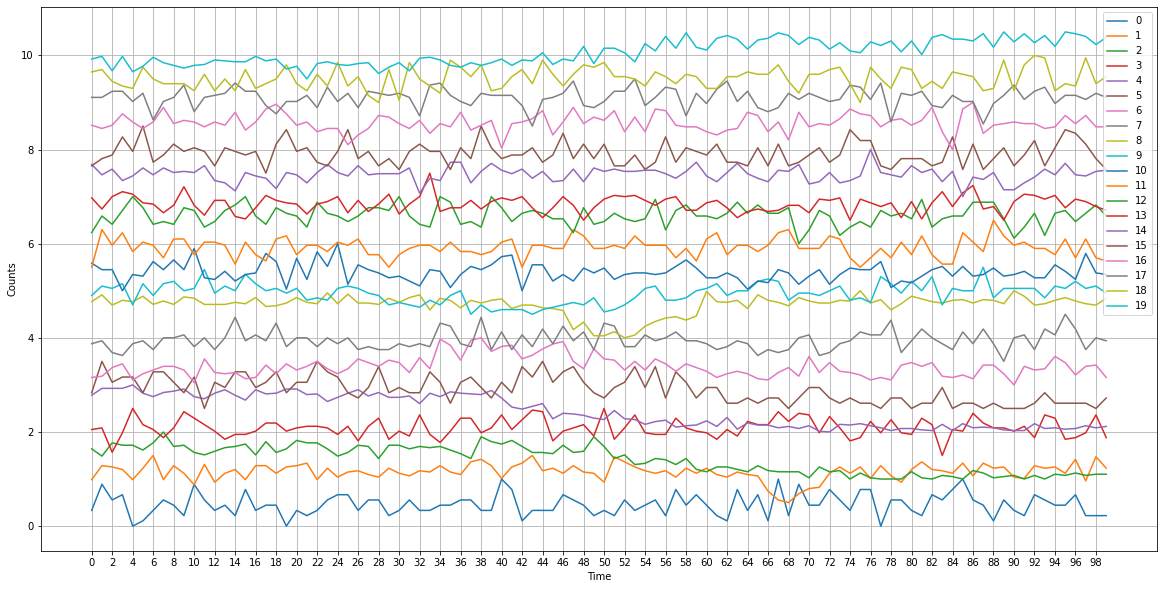

In [194]:
visualize_changes(X_train[:20])

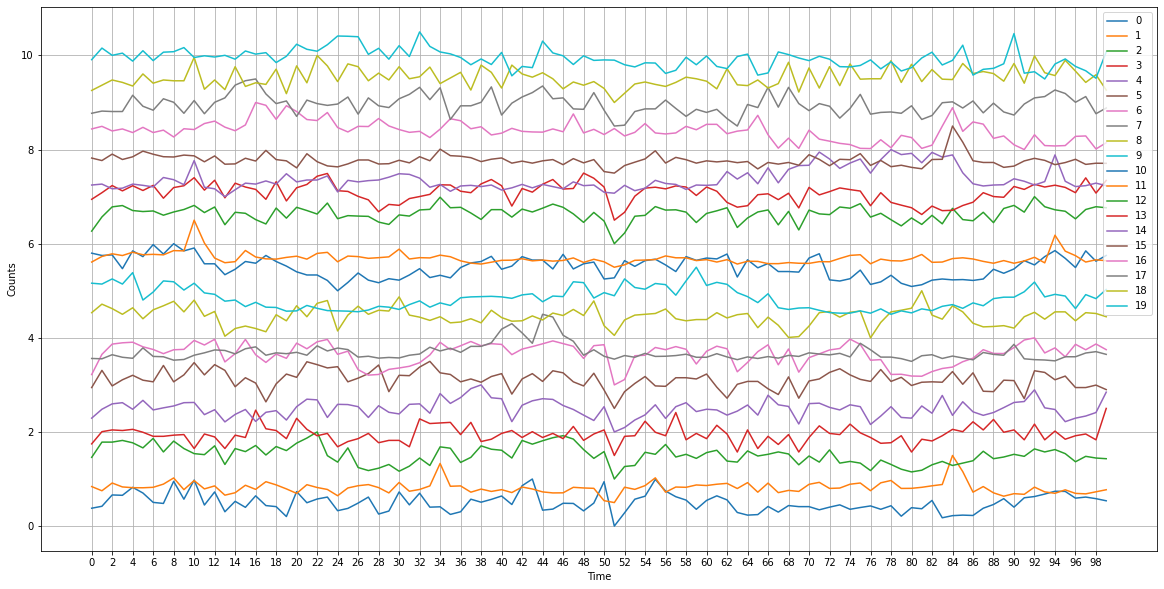

In [195]:
visualize_changes(stt_changes)

In [196]:
stt_bin, stt_seq = infer(model, stt_changes)

In [197]:
# stt_pred[:3]

In [198]:
def get_result_stt(y_pred):
    founds = []
    pivot_list = []
    
    for i, p in enumerate(y_pred):
        pivots = get_pivots(p)
        if len(pivots):
            founds.append(i)
            pivot_list.append(pivots)
    return founds, pivot_list

In [199]:
stt_result = get_result(stt_bin, stt_seq)

In [200]:
stt_result

[1, 6, 7, 9, 10, 12, 14, 15]

In [133]:
stt_seq[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

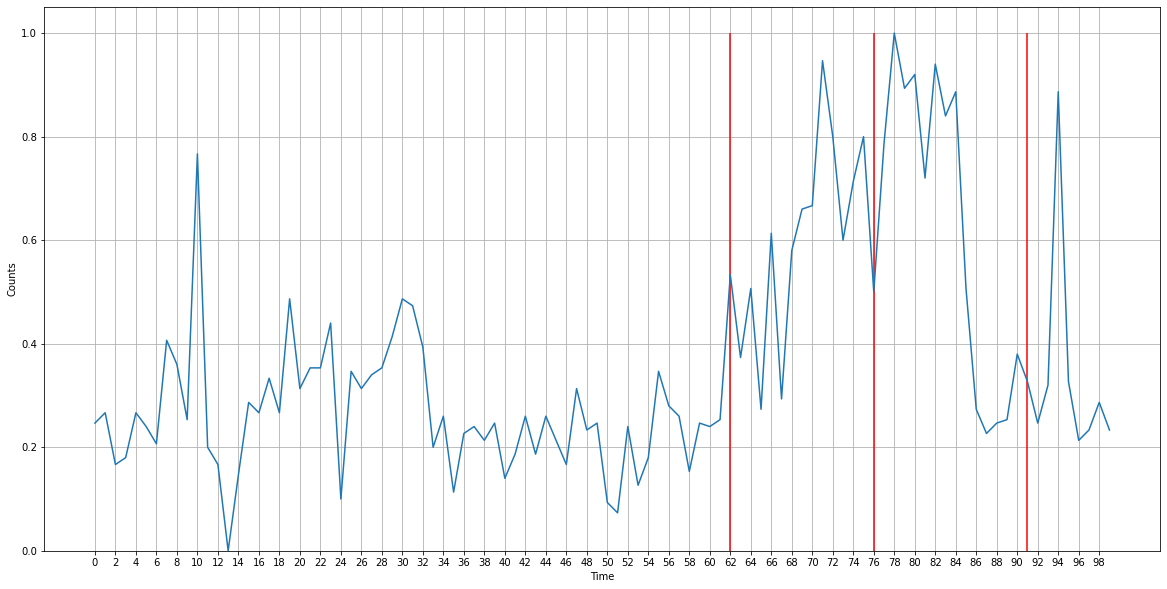

In [211]:
test_id = 14
visualize_train_data(stt_changes[test_id], get_pivots(stt_seq[test_id]))

In [118]:
def get_datetime(pivot_list):
    start = datetime.datetime(2007, 1, 1)
    date_list = []
    
    for pivots in pivot_list:
        dates = []
        for p in pivots:
            d = datetime.timedelta(days=p*7)
            end = start + d
            dates.append(end.strftime("%Y-%m-%d"))
        date_list.append(dates)
            
    return date_list
            

In [119]:
stt_dates = get_datetime(stt_pivots)

In [121]:
# stt_dates